# BAIXANDO O DATASET

In [ ]:
!pip install -U image_embeddings # don't run this line if running this directly in the repo

In [ ]:
!pip install pycocotools
!wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip
!unzip /content/annotations_trainval2017.zip

--2021-11-29 03:51:08--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.75.172
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.75.172|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip’

annotations_trainva 100%[===================>] 241.19M  34.3MB/s    in 8.0s    

2021-11-29 03:51:16 (30.2 MB/s) - ‘annotations_trainval2017.zip’ saved [252907541/252907541]

Archive:  /content/annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  


In [ ]:
import cv2
import numpy as np
import time
import pandas as pd
import os
from os import listdir
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import zipfile
from os.path import isfile, join
import csv 
from pycocotools.coco import COCO
import requests


In [ ]:
def createDirectory(name, animal):
    import os

 
    path = name
    access_rights = 0o755
    try:
        os.mkdir(path, access_rights)
    except OSError:
        print ("Creation of the directory %s failed" % path)
        
    else:
        print ("Successfully created the directory %s " % path)


def downloadValid(animal, coco, index):
    createDirectory('valid/', animal)
    cats = coco.loadCats(coco.getCatIds())
    nms=[cat['name'] for cat in cats]

    catIds = coco.getCatIds(catNms=[animal])

    imgIds = coco.getImgIds(catIds=catIds )
    images = coco.loadImgs(imgIds)

    i = 1
    for im in images:
        if i <= 50:
            img_data = requests.get(im['coco_url']).content
            
            with open('valid/'+ animal+'_'+im['file_name'], 'wb') as handler:
                handler.write(img_data)
            
            #time.sleep(3)    
            i = i + 1
        else:
            break




In [ ]:

coco = COCO('annotations/instances_val2017.json')
animals = [ 'bird',
            'cat',
            'dog',
            'horse',
            'sheep',
            'cow',
            'elephant',
            'bear',
            'zebra',
            'giraffe']
for item in animals:
  downloadValid(item, coco, animals.index(item))

loading annotations into memory...
Done (t=0.66s)
creating index...
index created!
Successfully created the directory valid/ 
Creation of the directory valid/ failed
Creation of the directory valid/ failed
Creation of the directory valid/ failed
Creation of the directory valid/ failed
Creation of the directory valid/ failed
Creation of the directory valid/ failed
Creation of the directory valid/ failed
Creation of the directory valid/ failed
Creation of the directory valid/ failed


# CRIANDO AS EMBEDDINGS

In [ ]:
#Tutorial de https://rom1504.medium.com/image-embeddings-ed1b194d113e

!mkdir embeddings
!mkdir tfrecords


In [ ]:
def redimensionar(imagem):
  imagem = cv2.resize(imagem, (224, 224),interpolation=cv2.INTER_CUBIC)
  return imagem



In [ ]:
mypath = f"/content/valid/"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

for img in onlyfiles:
  imagem = cv2.imread(f'/content/valid/{img}')
  novaImagem = redimensionar(imagem)
  cv2.imwrite(mypath+"/"+img, novaImagem)


In [ ]:
#Tf record is an efficient format to store image, it's better to use than raw image file for inference
import image_embeddings
path_images = "/content/valid"
path_tfrecords = "/content/tfrecords"
path_embeddings = "/content/embeddings"
image_embeddings.inference.write_tfrecord(image_folder=path_images,
                                          output_folder=path_tfrecords,
                                          num_shards=10)

Instructions for updating:
To write TFRecords to disk, use `tf.io.TFRecordWriter`. To save and load the contents of a dataset, use `tf.data.experimental.save` and `tf.data.experimental.load`
Shard 0 saved after 0s
Shard 1 saved after 0s
Shard 2 saved after 0s
Shard 3 saved after 0s
Shard 4 saved after 1s
Shard 5 saved after 1s
Shard 6 saved after 1s
Shard 7 saved after 1s
Shard 8 saved after 1s
Shard 9 saved after 1s


In [ ]:
#Construindo as embeddings
image_embeddings.inference.run_inference(tfrecords_folder=path_tfrecords,
                                         output_folder=path_embeddings,
                                         batch_size=100)

1/1 [==============================] - 4s 4s/step

Shard 0 done after 6s
Shard 0 saved after 6s
1/1 [==============================] - 2s 2s/step

Shard 1 done after 8s
Shard 1 saved after 8s
1/1 [==============================] - 2s 2s/step

Shard 2 done after 11s
Shard 2 saved after 11s
1/1 [==============================] - 2s 2s/step

Shard 3 done after 14s
Shard 3 saved after 14s
1/1 [==============================] - 2s 2s/step

Shard 4 done after 16s
Shard 4 saved after 16s
1/1 [==============================] - 2s 2s/step

Shard 5 done after 18s
Shard 5 saved after 19s
1/1 [==============================] - 2s 2s/step

Shard 6 done after 21s
Shard 6 saved after 21s
1/1 [==============================] - 2s 2s/step

Shard 7 done after 23s
Shard 7 saved after 23s
1/1 [==============================] - 2s 2s/step

Shard 8 done after 25s
Shard 8 saved after 26s
1/1 [==============================] - 2s 2s/step

Shard 9 done after 28s
Shard 9 saved after 28s


In [ ]:
[id_to_name, name_to_id, embeddings] = image_embeddings.knn.read_embeddings(path_embeddings)
#Resultado final, 500 registros para 1280 características
print(embeddings.shape)
print(id_to_name)
print(name_to_id)

(499, 1280)
{0: 'bear_000000000285', 1: 'bear_000000127955', 2: 'bear_000000229997', 3: 'bear_000000361180', 4: 'bear_000000513484', 5: 'bird_000000031322', 6: 'bird_000000147498', 7: 'bird_000000229997', 8: 'bird_000000330369', 9: 'bird_000000490125', 10: 'cat_000000063552', 11: 'cat_000000119828', 12: 'cat_000000269314', 13: 'cat_000000357941', 14: 'cat_000000456292', 15: 'cow_000000016010', 16: 'cow_000000152740', 17: 'cow_000000267434', 18: 'cow_000000347664', 19: 'cow_000000435206', 20: 'dog_000000049269', 21: 'dog_000000182805', 22: 'dog_000000355905', 23: 'dog_000000401991', 24: 'dog_000000489014', 25: 'elephant_000000057027', 26: 'elephant_000000158945', 27: 'elephant_000000245915', 28: 'elephant_000000356125', 29: 'elephant_000000475779', 30: 'giraffe_000000079565', 31: 'giraffe_000000217614', 32: 'giraffe_000000286849', 33: 'giraffe_000000383676', 34: 'giraffe_000000471567', 35: 'horse_000000015956', 36: 'horse_000000172547', 37: 'horse_000000242724', 38: 'horse_000000356968'

# REDUZINDO DIMENSIONALIDADE COM T-SNE


In [ ]:
from sklearn.manifold import TSNE

m = TSNE(learning_rate=50)

tsne_features = m.fit_transform(embeddings)

print(tsne_features.shape)



/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


(499, 2)


In [ ]:

df = pd.DataFrame(tsne_features, columns=['x', 'y'])

mypath = f"/content/valid/"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]

imagensOrdenadas = sorted(onlyfiles)

df['ImageName'] = id_to_name.values()

classesOriginais = []
for item in id_to_name:
  classesOriginais.append(id_to_name[item].split("_")[0])
  
df['ClasseOriginal'] = classesOriginais

df


,x,y,ImageName,ClasseOriginal
0,3.695552,-5.430679,bear_000000000285,bear
1,-1.333725,-5.267606,bear_000000127955,bear
2,-7.111206,18.551336,bear_000000229997,bear
3,2.176559,-6.523255,bear_000000361180,bear
4,-0.856794,-6.143190,bear_000000513484,bear
...,...,...,...,...
494,-21.496111,-20.640182,zebra_000000001818,zebra
495,-20.754087,-19.460228,zebra_000000070158,zebra
496,-20.797899,-18.468517,zebra_000000159311,zebra
497,-17.767418,-20.203308,zebra_000000317024,zebra


SCATTER PLOT

In [ ]:
import plotly.figure_factory as ff
import plotly.express as px
import plotly.io as pio
import seaborn as sns
import numpy as np

scatter = px.scatter(df,
    x="x", y="y",
    marginal_x="histogram", marginal_y="violin",
    color="ClasseOriginal", hover_data=['ImageName'])
scatter.show()

# CRIANDO UM MODELO EFFICIENTNET COM O KERAS

In [ ]:
from efficientnet.tfkeras import EfficientNetB0, preprocess_input

model = EfficientNetB0(weights='imagenet')  # or weights='noisy-student'

model.summary()

21839872/21826536 [==============================] - 1s 0us/step
Model: "efficientnet-b0"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 stem_conv (Conv2D)             (None, 112, 112, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 stem_bn (BatchNormalization)   (None, 112, 112, 32  128         ['stem_conv[0][0]']              
                   

# SHAP AI

In [ ]:
!pip install shap

     |████████████████████████████████| 371 kB 14.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for shap: filename=shap-0.40.0-cp37-cp37m-linux_x86_64.whl size=509229 sha256=2ec410154c5a2bb33a5b8c085a7394f0e14430b76216efe0bb8053e1e1dd5e01
  Stored in directory: /root/.cache/pip/wheels/ec/35/84/e304841ac4b910bc95fe9a6e5302eb2507b4333728851dcbfb
Successfully built shap


In [ ]:
from numpy import asarray

def TransformImageForSHAP(display=False, resolution=416): # pylint: disable=unused-argument
    arrayImagens = []
    i = 0
    for img in onlyfiles:
      print(f"ID{i} - {img}")
      imagem = cv2.imread(f'/content/valid/{img}')
      arrayImagens.append(np.array(imagem.astype('float32')))
      i = i + 1
    return np.array(arrayImagens)

ID0 - zebra_000000320632.jpg
ID1 - zebra_000000113354.jpg
ID2 - bear_000000203546.jpg
ID3 - bear_000000217948.jpg
ID4 - bear_000000312586.jpg
ID5 - cat_000000119828.jpg
ID6 - elephant_000000415748.jpg
ID7 - horse_000000381971.jpg
ID8 - horse_000000226883.jpg
ID9 - bird_000000186422.jpg
ID10 - cat_000000116825.jpg
ID11 - bear_000000243075.jpg
ID12 - zebra_000000377497.jpg
ID13 - cat_000000435299.jpg
ID14 - cow_000000455219.jpg
ID15 - bird_000000482477.jpg
ID16 - bear_000000235064.jpg
ID17 - zebra_000000025096.jpg
ID18 - horse_000000029187.jpg
ID19 - dog_000000205834.jpg
ID20 - bear_000000375015.jpg
ID21 - giraffe_000000469652.jpg
ID22 - sheep_000000046804.jpg
ID23 - cow_000000105264.jpg
ID24 - horse_000000185473.jpg
ID25 - horse_000000377486.jpg
ID26 - bear_000000318080.jpg
ID27 - horse_000000148999.jpg
ID28 - cow_000000435206.jpg
ID29 - sheep_000000559956.jpg
ID30 - giraffe_000000235252.jpg
ID31 - horse_000000348243.jpg
ID32 - giraffe_000000475150.jpg
ID33 - zebra_000000454750.jpg
ID34

  0%|          | 0/48 [00:00<?, ?it/s]

Partition explainer:  50%|█████     | 1/2 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

Partition explainer: 3it [00:23, 11.64s/it]


2


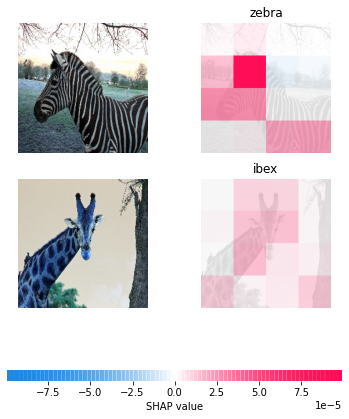

In [ ]:

import json
import shap
X = TransformImageForSHAP()

url = "https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json"
with open(shap.datasets.cache(url)) as file:
    class_names = [v[1] for v in json.load(file).values()]

def f(x):
    tmp = x.copy()
    preprocess_input(tmp)
    return model(tmp)


masker = shap.maskers.Image("inpaint_telea", X[0].shape)


explainer = shap.Explainer(f, masker, output_names=class_names)


shap_values = explainer(X[345:347], max_evals=100, batch_size=50, outputs=shap.Explanation.argsort.flip[:1])

print(len(shap_values))
shap.image_plot(shap_values)

In [ ]:
#TRANSFORMANDO O DATAFRAME EM CSV

df.to_csv("DadosEmbeddingsNormalizados.csv",encoding='utf-8', index=False)

#AGORA SÓ BAIXAR O CSV